# Pylops - Least squares image-domain migration - SEAM model

### Author: M.Ravasi

In this notebook we show how to use the ``NonStationaryConvolve3D`` operator to perform image-domain least-squares migration. We will however here simply create some PSFs without a migration/demigation engine.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import filtfilt
from numba import jit

from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.avo.poststack              import PoststackLinearModelling, PoststackInversion

from pylops.optimization.basic         import *
from pylops.optimization.sparsity      import *

from visual import explode_volume

## Model and data creation

Lets' create a model and geometry

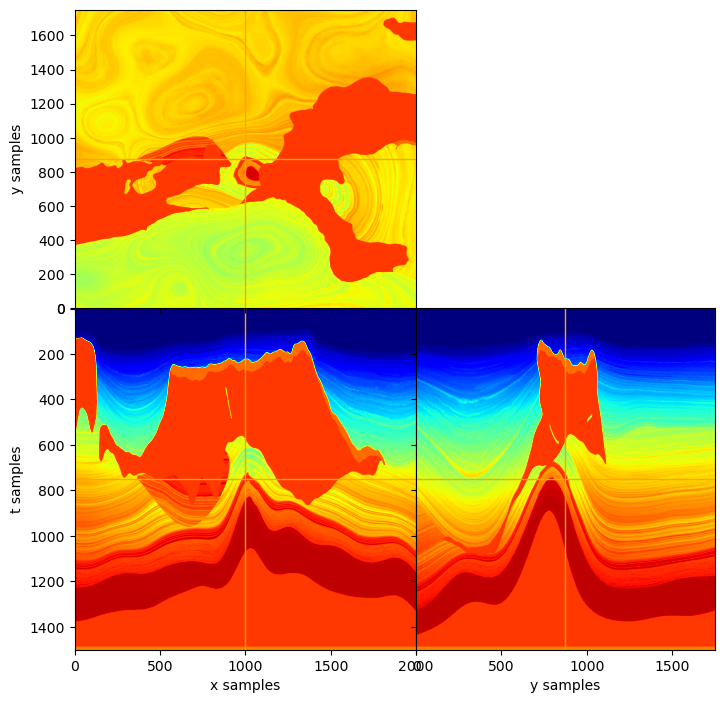

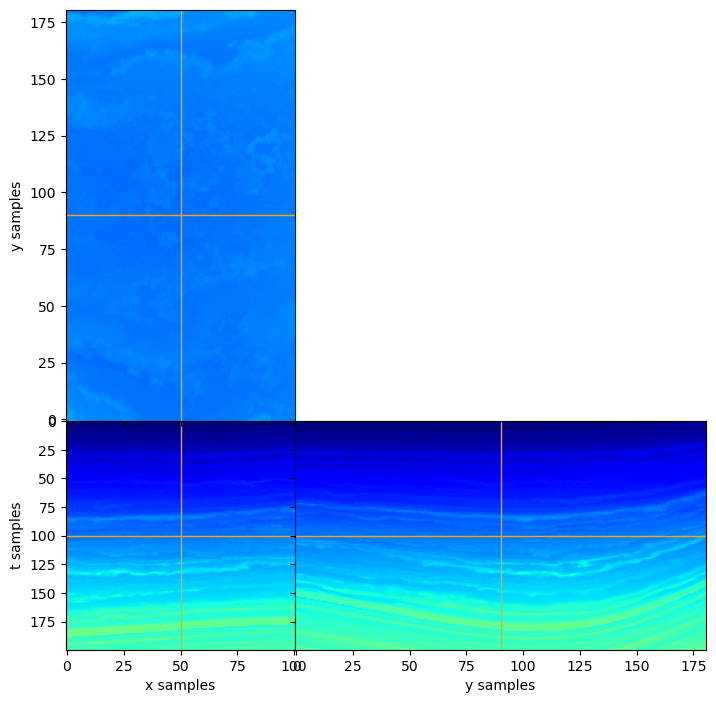

In [2]:
# Dimensions
nz, ny, nx = 1501, 2001, 1751
dz, dy, dx = 10, 20, 20

# Velocity
vel_true = np.fromfile('/mnt/datawaha_dig/Data/Seam_Phase1/Vp', dtype='<f')
vel_true = vel_true.reshape(nz, ny, nx).transpose(1, 2, 0)

explode_volume(vel_true.transpose(2, 0, 1), cmap='jet', clipval=(1500, 5000))

# Reduce model size and save
vel_true = vel_true[::2,::2,::2][:101, :181, 101:301]
ny, nx, nz = vel_true.shape
np.save('SeamVp', vel_true)

explode_volume(vel_true.transpose(2, 0, 1), cmap='jet', clipval=(1500, 5000))

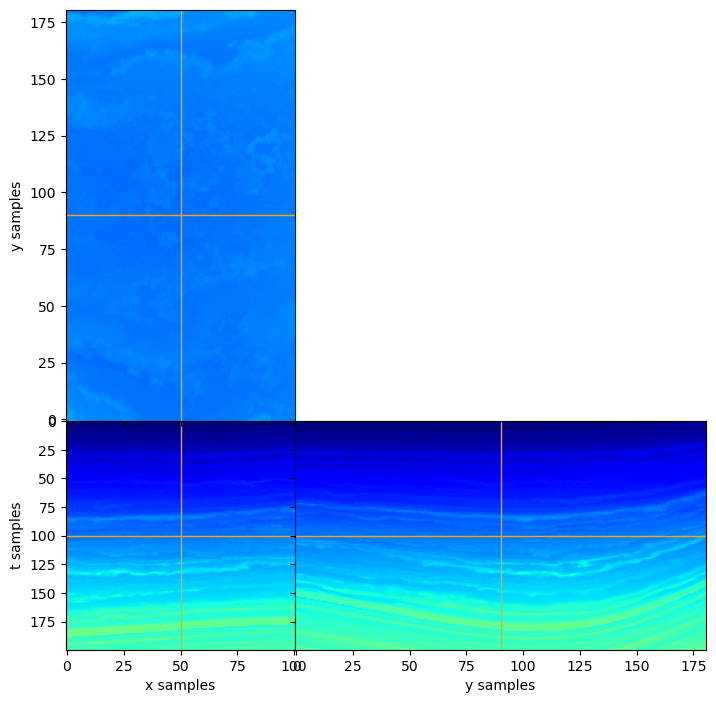

In [3]:
# Load model
vel_true = np.load('SeamVp.npy')
ny, nx, nz = vel_true.shape
dz, dy, dx = 20, 20, 20

explode_volume(vel_true.transpose(2, 0, 1), cmap='jet', clipval=(1500, 5000))

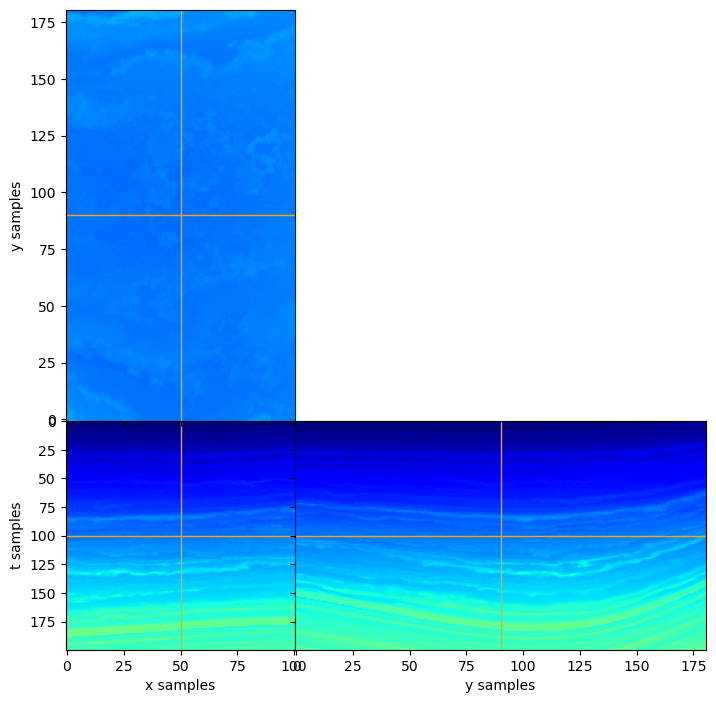

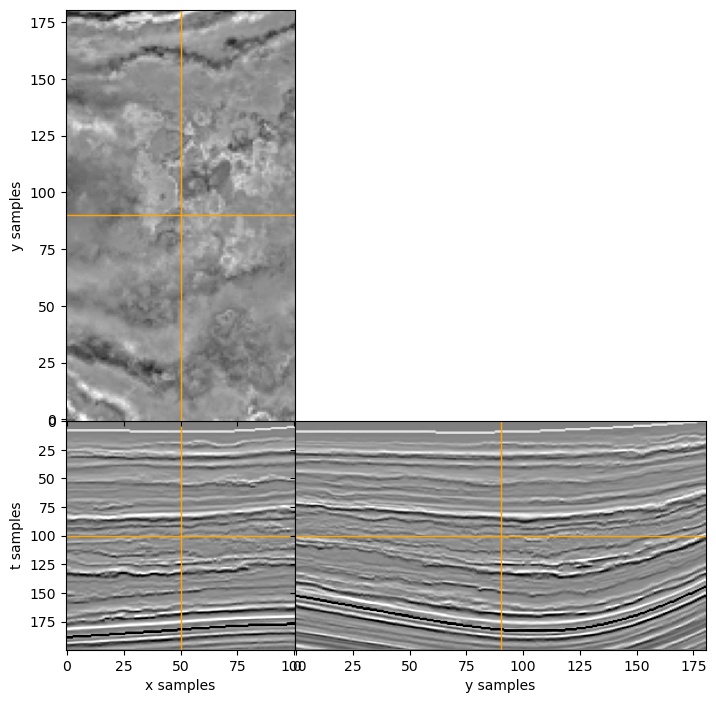

In [4]:
# Impedance
rho = 1.
ip_true = rho * vel_true

# Reflectivity
Dop = FirstDerivative(dims=(ny, nx, nz), axis=2)
refl = Dop * np.log(ip_true)

explode_volume(vel_true.transpose(2, 0, 1), cmap='jet', clipval=(1500, 5000))
explode_volume(refl.transpose(2, 0, 1), cmap='gray')

[20 70] [ 20  70 120] [ 20  70 120 170] 101 181 200


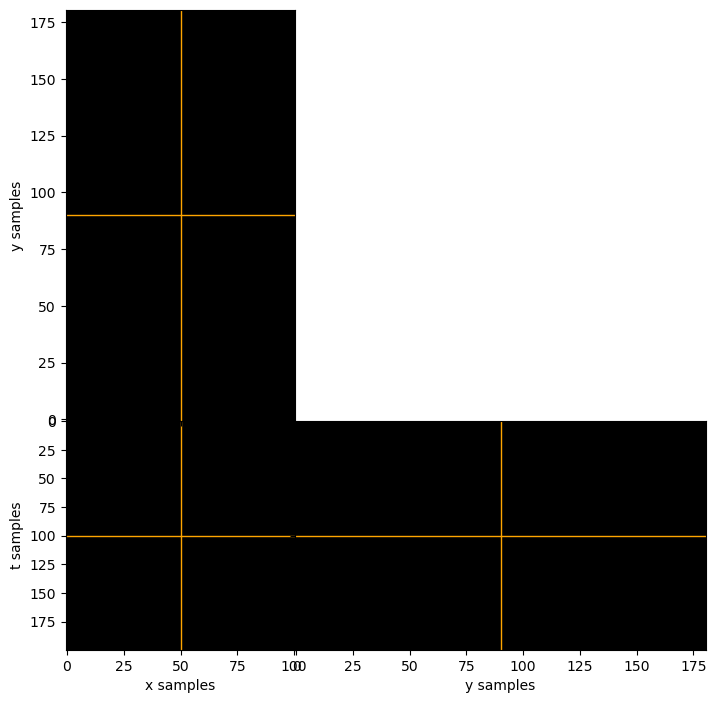

In [5]:
# PSF Model
psfrefl = np.zeros((ny, nx, nz))
psfin = (20, 20, 20)
psfend = (-19, -19, -19)
psfj = (50, 50, 50)
psfsize = (15, 15, 15)

ipsfy = np.arange(psfin[0], ny+psfend[0], psfj[0])
ipsfx = np.arange(psfin[1], nx+psfend[1], psfj[1])
ipsfz = np.arange(psfin[2], nz+psfend[2], psfj[2])
print(ipsfy, ipsfx, ipsfz, ny, nx, nz)

for iy in ipsfy:
    for ix in ipsfx:
        for iz in ipsfz:
            psfrefl[iy, ix, iz] = 1

explode_volume(psfrefl.transpose(2, 0, 1), cmap='gray', clipval=(0, 1))

### Synthetic PSF creation

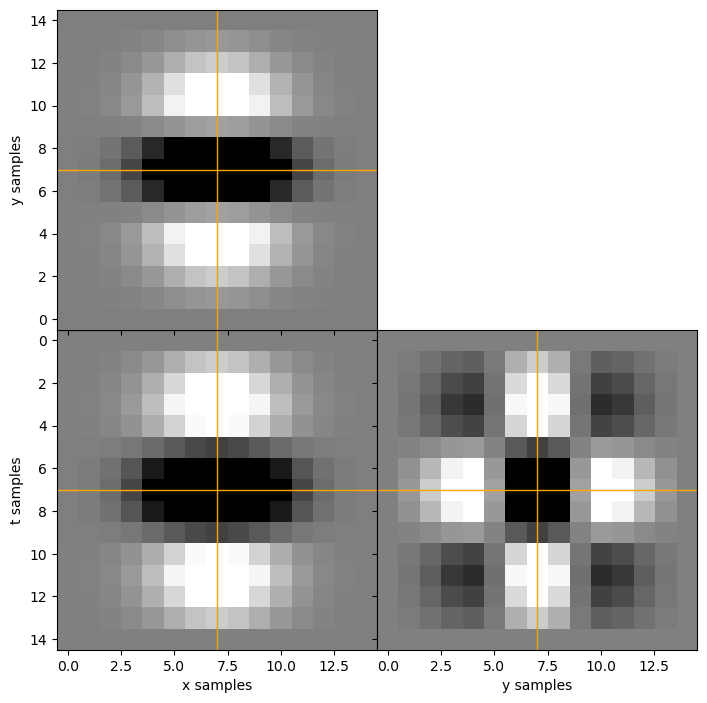

In [6]:
dt = 0.004
t = np.arange(nz)*dt

wav1a, _, wav1c = ricker(t[:psfsize[-1]//2], f0=25)
wav1b = -ricker(t[:psfsize[-1]//2], f0=30)[0]
wav1a = np.pad(wav1a, (1,1))
wav1b = np.pad(wav1b, (1,1))
wav2 = sp.signal.windows.gaussian(psfsize[1], 2.)

wav11 = np.outer(wav1b, np.outer(wav1a, wav2[np.newaxis]).T).reshape(psfsize)
wav11 = wav11.transpose(1, 0, 2)
wavsize = wav11.shape

explode_volume(wav11.transpose(2, 0, 1), cmap='gray')

In [8]:
hs = np.zeros((len(ipsfy), len(ipsfx), len(ipsfz), *wavsize))

for iy in range(len(ipsfy)):
    for ix in range(len(ipsfx)):
        for iz in range(len(ipsfz)):
            hs[iy, ix, iz] = wav11
            
Copcp = NonStationaryConvolve3D(hs=cp.asarray(hs), ihx=ipsfy, ihy=ipsfx, 
                                ihz=ipsfz, dims=(ny, nx, nz), 
                                num_threads_per_blocks=(8, 8, 8), engine="cuda", 
                                dtype=np.float32)

dottest(Copcp, verb=True, backend='cupy', atol=1e-1);

Dot test passed, v^H(Opu)=4912.9697265625 - u^H(Op^Hv)=4912.9814453125


## Deconvolution

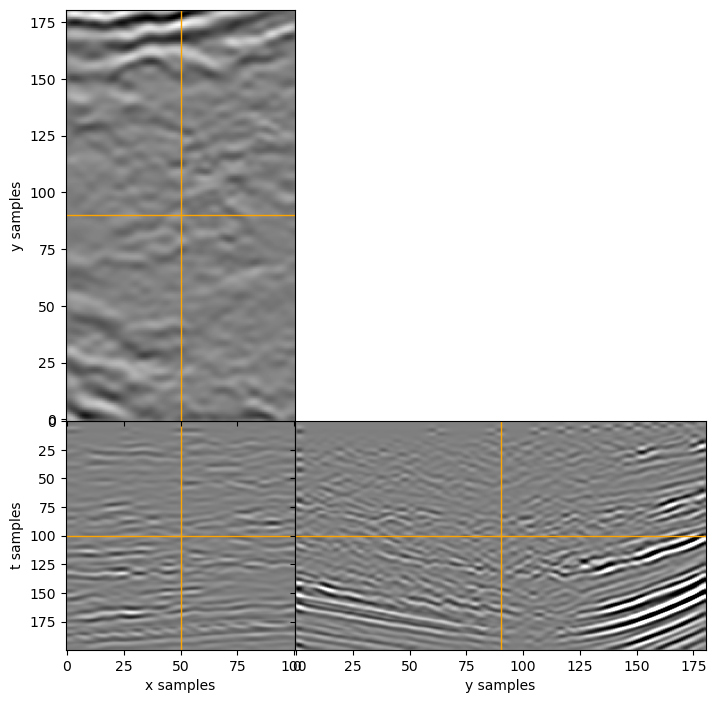

In [9]:
# Forward
reflcp = cp.asarray(refl.astype(np.float32))

# Data creation
mmigcp = Copcp @ reflcp
mmig = cp.asnumpy(mmigcp)

explode_volume(mmig.transpose(2, 0, 1), cmap='gray')

LSQR
------------------------------------------------------------------------------------------
The Operator Op has 3656200 rows and 3656200 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08                 niter =       50
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  3.517e+02  3.517e+02   1.0e+00  1.3e-01
     1  2.6795e-05  1.967e+02  1.967e+02   5.6e-01  4.1e-01  5.5e+01  1.0e+00
     2  4.6748e-05  1.343e+02  1.343e+02   3.8e-01  2.3e-01  7.4e+01  2.2e+00
     3  5.9338e-05  1.034e+02  1.034e+02   2.9e-01  1.6e-01  9.0e+01  3.6e+00
     4  6.9574e-05  8.436e+01  8.436e+01   2.4e-01  1.1e-01  1.0e+02  5.2e+00
     5  7.5362e-05  7.136e+01  7.136e+01   2.0e-01  8.9e-02  1.2e+02  7.0e+00
     6  7.1075e-05  6.183e+01  6.183e+01   1.8e-01  7.2e-02  1.3e+02  8.9e+00
     7  5

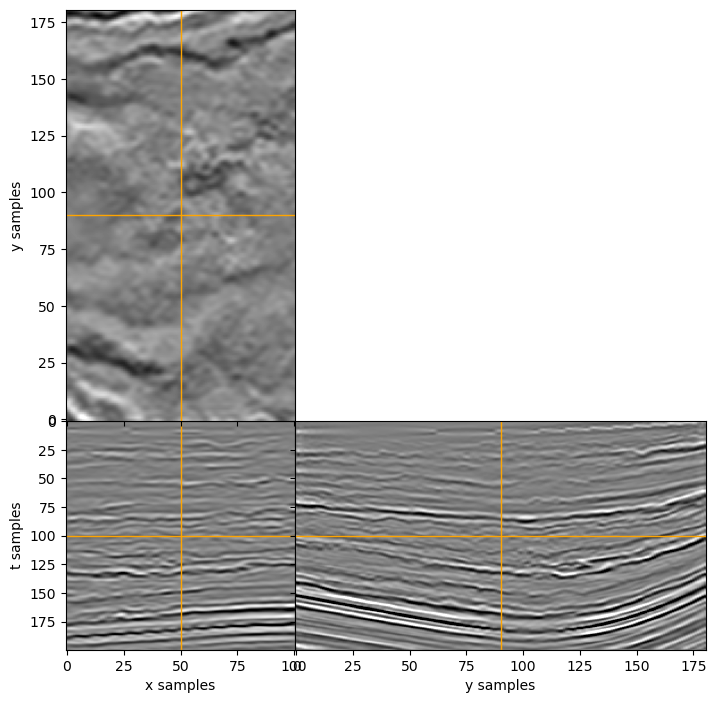

In [10]:
# Inversion
minvcp = lsqr(Copcp, mmigcp.ravel(), niter=50, show=True)[0]
minv = cp.asnumpy(minvcp)

explode_volume(minv.transpose(2, 0, 1), cmap='gray')